In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2  # OpenCV görüntü işlemleri için kullanacağız.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
data_dir = 'C:/Users/User/Desktop/MURA-v1.1'  # Veri setinin yolu
categories = ['train', 'valid']

# Klasör içindeki alt grupları görelim
for category in categories:
    path = os.path.join(data_dir, category)
    print(f"{category} klasöründe bulunan gruplar:")
    print(os.listdir(path))


train klasöründe bulunan gruplar:
['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
valid klasöründe bulunan gruplar:
['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


In [4]:
# Görüntü boyutları
img_height, img_width = 224, 224  # ResNet veya VGG gibi modeller için standart boyut
batch_size = 32  # Her iterasyonda modele verilen görüntü sayısı

# Eğitim seti için veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalizasyon: [0, 255] -> [0, 1]
    shear_range=0.2,           # Hafif kesme dönüşümü
    zoom_range=0.2,            # Yakınlaştırma dönüşümü
    horizontal_flip=True       # Yatay çevirme
)

# Doğrulama seti için sadece normalizasyon
valid_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim setini yükleme
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),  # Eğitim setinin yolu
    target_size=(img_height, img_width),  # Görüntü boyutları
    batch_size=batch_size,
    class_mode='categorical'  # Sınıf tipi: categorical (çok sınıflı sınıflandırma)
)

# Doğrulama setini yükleme
valid_generator = valid_datagen.flow_from_directory(
    os.path.join(data_dir, 'valid'),  # Doğrulama setinin yolu
    target_size=(img_height, img_width),  # Görüntü boyutları
    batch_size=batch_size,
    class_mode='categorical'  # Sınıf tipi: categorical (çok sınıflı sınıflandırma)
)


Found 36808 images belonging to 7 classes.
Found 3197 images belonging to 7 classes.


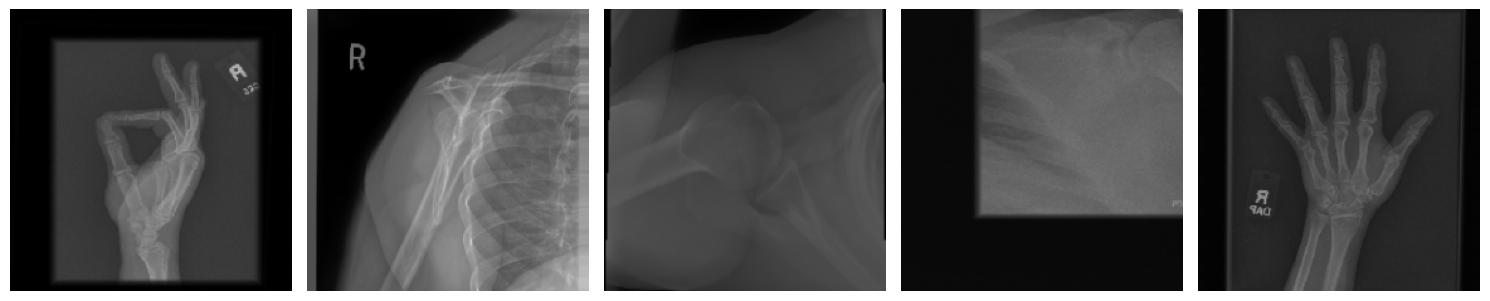

In [5]:
# Eğitim setinden bir batch (küme) alalım
images, labels = next(train_generator)

# İlk 5 görüntüyü görselleştirme
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()
for img, ax in zip(images[:5], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [6]:
model = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Giriş boyutunu belirleme
    
    # 1. Convolutional Katman
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 2. Convolutional Katman
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3. Convolutional Katman
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Tam Bağlantılı Katmanlar
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Çıkış katmanı (7 sınıf için softmax)
    Dense(7, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Çok sınıflı kayıp fonksiyonu
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='adam',                # Optimizasyon yöntemi
    loss='binary_crossentropy',      # Binary sınıflandırma için uygun kayıp fonksiyonu
    metrics=['accuracy']             # Performans metriği
)


In [8]:
import numpy as np

# Eğitim ve doğrulama setindeki etiketlerin kontrolü
train_labels = train_generator.labels
valid_labels = valid_generator.labels

print("Eğitim seti etiketleri: ", np.unique(train_labels))
print("Doğrulama seti etiketleri: ", np.unique(valid_labels))


Eğitim seti etiketleri:  [0 1 2 3 4 5 6]
Doğrulama seti etiketleri:  [0 1 2 3 4 5 6]


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=10
)


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 479s 415ms/step - accuracy: 0.5589 - loss: 0.2878 - val_accuracy: 0.7448 - val_loss: 0.1930
Epoch 2/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 470s 409ms/step - accuracy: 0.7765 - loss: 0.1663 - val_accuracy: 0.8026 - val_loss: 0.1468
Epoch 3/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 468s 407ms/step - accuracy: 0.8154 - loss: 0.1375 - val_accuracy: 0.8255 - val_loss: 0.1280
Epoch 4/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 466s 405ms/step - accuracy: 0.8431 - loss: 0.1198 - val_accuracy: 0.8577 - val_loss: 0.1097
Epoch 5/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 467s 406ms/step - accuracy: 0.8624 - loss: 0.1066 - val_accuracy: 0.8646 - val_loss: 0.1062
Epoch 6/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 469s 407ms/step - accuracy: 0.8814 - loss: 0.0936 - val_accuracy: 0.8815 - val_loss: 0.0942
Epoch 7/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 471s 409ms/step - accuracy: 0.8929 - loss: 0.0862 - val_accuracy: 0.8890 - val_loss: 0.0901
Epoch 8/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 471s 409ms/step - ac

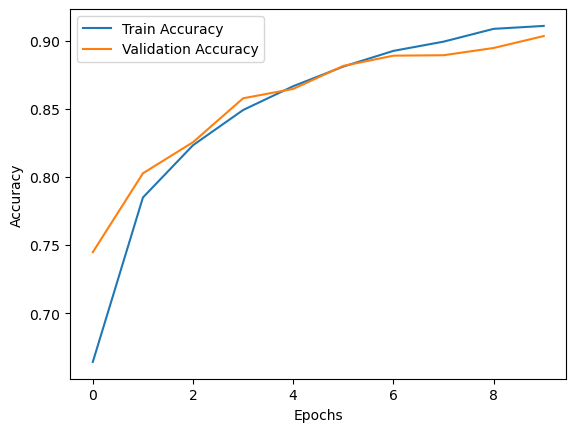

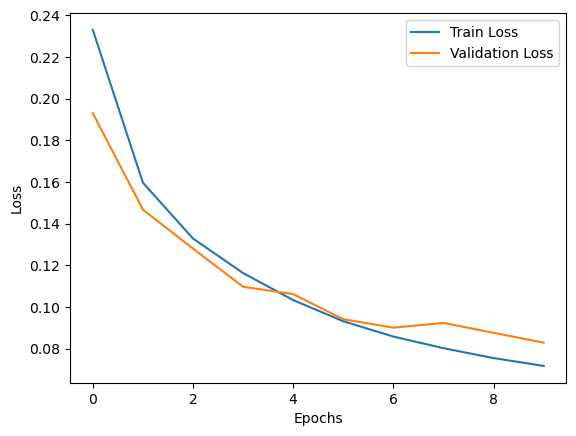

In [10]:
# Eğitim ve doğrulama doğruluğunu çizme
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını çizme
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
# Modelinizi kaydetmek için
model.save('cnn_model.h5')
# Saving the model in the new Keras format
model.save('my_model.keras')
